In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
#from sklearn.metrics import root_mean_squared_error

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
import optuna

In [47]:
sales = pd.read_csv('sales_train.csv')
sales.head(5)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [48]:
sales.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


In [49]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [50]:
sales['date'] = pd.to_datetime(sales['date'], dayfirst=True)

In [51]:
sales

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,2015-10-10,33,25,7409,299.00,1.0
2935845,2015-10-09,33,25,7460,299.00,1.0
2935846,2015-10-14,33,25,7459,349.00,1.0
2935847,2015-10-22,33,25,7440,299.00,1.0


In [52]:
sales = sales[sales['item_cnt_day']>0]
sales.shape

(2928493, 6)

In [53]:
sales1=sales.copy()
sales1['year']=sales1["date"].dt.year
sales1['month']=sales1["date"].dt.month
sales1['day']=sales1["date"].dt.day
sales_gr=sales1.groupby(['date','year', 'month', 'day', 'date_block_num'])['item_cnt_day'].sum().reset_index()
sales_gr


,date,year,month,day,date_block_num,item_cnt_day
0,2013-01-01,2013,1,1,0,1957.0
1,2013-01-02,2013,1,2,0,8232.0
2,2013-01-03,2013,1,3,0,7444.0
3,2013-01-04,2013,1,4,0,6628.0
4,2013-01-05,2013,1,5,0,6360.0
...,...,...,...,...,...,...
1029,2015-10-27,2015,10,27,33,1555.0
1030,2015-10-28,2015,10,28,33,3599.0
1031,2015-10-29,2015,10,29,33,1591.0
1032,2015-10-30,2015,10,30,33,2277.0


## Сгруппировал датасет по дням, количество проданных товаров просуммировал.

In [54]:
sales_gr1 = sales_gr[['date','item_cnt_day']].set_index('date')
sales_gr1

,item_cnt_day
date,
2013-01-01,1957.0
2013-01-02,8232.0
2013-01-03,7444.0
2013-01-04,6628.0
2013-01-05,6360.0
...,...
2015-10-27,1555.0
2015-10-28,3599.0
2015-10-29,1591.0


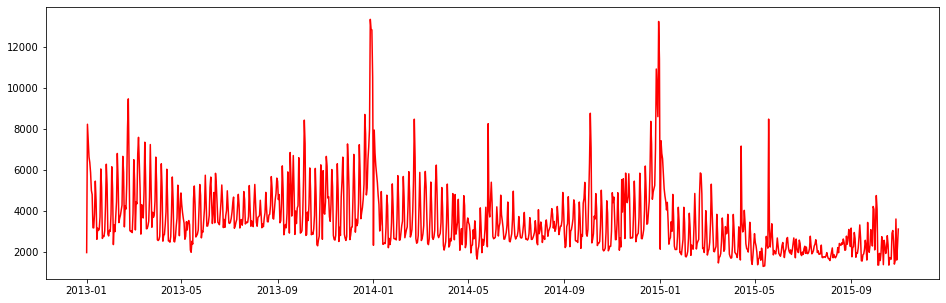

In [55]:
plt.figure(figsize=(16, 5))

plt.plot(sales_gr1.index, sales_gr1['item_cnt_day'], label='total', color='r')

## Виден явный тренд и сезонность 

<Figure size 1152x864 with 0 Axes>

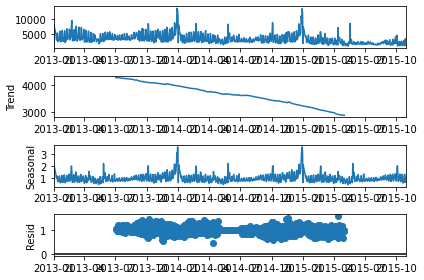

In [56]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(sales_gr1, 
                            model='multiplicative',
                            period=365)
plt.figure(figsize=(16,12))
result.plot();

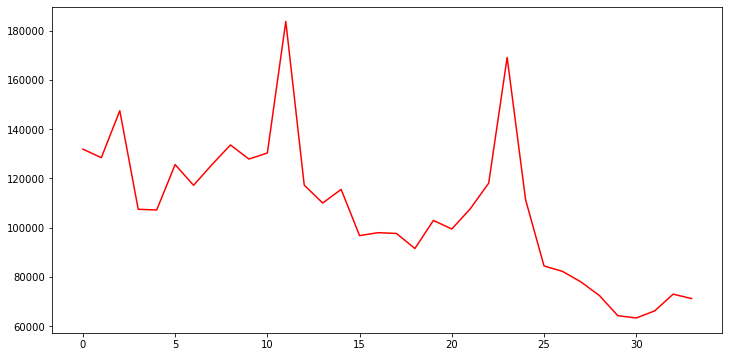

In [57]:
sales_gr3 = sales1.groupby(['date_block_num'])['item_cnt_day'].sum().reset_index()
plt.figure(figsize=(12, 6))
sales_gr3.astype("float")

plt.plot(sales_gr3['date_block_num'], sales_gr3['item_cnt_day'], label='total', color='r')

In [58]:
def code_mean(data, cat_feature, real_feature):
    return dict(data.groupby(cat_feature)[real_feature].mean())

In [114]:
df = pd.DataFrame(sales_gr1.copy())
df.head()

,item_cnt_day
date,
2013-01-01,1957.0
2013-01-02,8232.0
2013-01-03,7444.0
2013-01-04,6628.0
2013-01-05,6360.0


In [118]:
df=df.reset_index()
df

,date,item_cnt_day
0,2013-01-01,1957.0
1,2013-01-02,8232.0
2,2013-01-03,7444.0
3,2013-01-04,6628.0
4,2013-01-05,6360.0
...,...,...
1029,2015-10-27,1555.0
1030,2015-10-28,3599.0
1031,2015-10-29,1591.0
1032,2015-10-30,2277.0


In [119]:
test_index = int(len(df) * 0.8)
test_index

827

## Добавил дополнительные признаки: день недели, месяц и год закодировал средним значением целевой переменной; добавил три лага

In [120]:
df["weekday"] = df['date'].dt.weekday
df["month"] = df['date'].dt.month
df["year"] = df['date'].dt.year

In [121]:
code_mean(df[:test_index], "weekday", "item_cnt_day").get

<function dict.get(key, default=None, /)>

In [122]:
df["weekday_average"] = list(map(code_mean(df[:test_index], "weekday", "item_cnt_day").get, df.weekday))
df["month_average"] = list(map(code_mean(df[:test_index], "month", "item_cnt_day").get, df.month))
df["year_average"] = list(map(code_mean(df[:test_index], "year", "item_cnt_day").get, df.year))
df.drop(["weekday", 'month', 'year', 'date'], axis=1, inplace=True)

In [123]:
for i in range(1, 4):
        df[f"lag_{i}"] = df.item_cnt_day.shift(i)
df

,item_cnt_day,weekday_average,month_average,year_average,lag_1,lag_2,lag_3
0,1957.0,3234.655462,3875.182796,4290.128767,NaN,NaN,NaN
1,8232.0,3190.203390,3875.182796,4290.128767,1957.0,NaN,NaN
2,7444.0,3354.838983,3875.182796,4290.128767,8232.0,1957.0,NaN
3,6628.0,4107.694915,3875.182796,4290.128767,7444.0,8232.0,1957.0
4,6360.0,5524.830508,3875.182796,4290.128767,6628.0,7444.0,8232.0
...,...,...,...,...,...,...,...
1029,1555.0,3234.655462,3797.387097,3035.051546,1393.0,2498.0,3037.0
1030,3599.0,3190.203390,3797.387097,3035.051546,1555.0,1393.0,2498.0
1031,1591.0,3354.838983,3797.387097,3035.051546,3599.0,1555.0,1393.0
1032,2277.0,4107.694915,3797.387097,3035.051546,1591.0,3599.0,1555.0


In [124]:
df=df.dropna()
df.reset_index(drop=True)

,item_cnt_day,weekday_average,month_average,year_average,lag_1,lag_2,lag_3
0,6628.0,4107.694915,3875.182796,4290.128767,7444.0,8232.0,1957.0
1,6360.0,5524.830508,3875.182796,4290.128767,6628.0,7444.0,8232.0
2,5869.0,4580.923729,3875.182796,4290.128767,6360.0,6628.0,7444.0
3,5000.0,2961.567797,3875.182796,4290.128767,5869.0,6360.0,6628.0
4,4795.0,3234.655462,3875.182796,4290.128767,5000.0,5869.0,6360.0
...,...,...,...,...,...,...,...
1026,1555.0,3234.655462,3797.387097,3035.051546,1393.0,2498.0,3037.0
1027,3599.0,3190.203390,3797.387097,3035.051546,1555.0,1393.0,2498.0
1028,1591.0,3354.838983,3797.387097,3035.051546,3599.0,1555.0,1393.0
1029,2277.0,4107.694915,3797.387097,3035.051546,1591.0,3599.0,1555.0


In [125]:
df.describe()

,item_cnt_day,weekday_average,month_average,year_average,lag_1,lag_2,lag_3
count,1031.000000,1031.000000,1031.000000,1031.000000,1031.000000,1031.000000,1031.000000
mean,3528.723569,3852.546652,3797.227735,3685.040042,3532.930165,3538.706111,3539.061106
std,1576.225739,867.554715,535.303426,504.576540,1580.879533,1587.152608,1586.757427
min,1279.000000,2961.567797,3293.014925,3035.051546,1279.000000,1279.000000,1279.000000
25%,2479.500000,3190.203390,3365.645161,3035.051546,2479.500000,2484.000000,2484.000000
50%,3155.000000,3354.838983,3720.100000,3626.284932,3156.000000,3158.000000,3158.000000
75%,4252.500000,4580.923729,3875.182796,4290.128767,4260.000000,4267.500000,4267.500000
max,13362.000000,5524.830508,5689.112903,4290.128767,13362.000000,13362.000000,13362.000000


In [126]:
X_train = df.loc[:test_index].drop(["item_cnt_day"], axis=1)
y_train = df.loc[:test_index]["item_cnt_day"]
X_test = df.loc[test_index:].drop(["item_cnt_day"], axis=1)
y_test = df.loc[test_index:]["item_cnt_day"]

## Обучил линейную регрессию размер тестовой выборки 0.8 от всего датасета

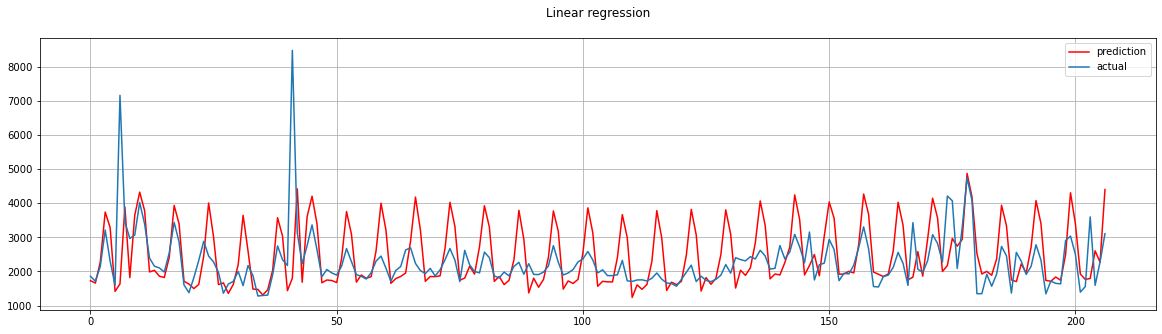

In [127]:
lr = LinearRegression()
lr.fit(X_train, y_train)
preds = lr.predict(X_test)

plt.figure(figsize=(20, 5))
plt.plot(preds, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.grid(True)
plt.legend(loc="best")
plt.title(f"Linear regression\n");

In [91]:
print(f'Mean absolute error {mean_absolute_error(y_test, preds)}')
print(f'Mean absolute percetage error {mean_absolute_percentage_error(y_test, preds)}')
print(f'Mean squared error {mean_squared_error(y_test, preds)}')
#print(f'RMSE {root_mean_squared_error(y_test, preds)}')

Mean absolute error 613.282285729185
Mean absolute percetage error 0.2509143479713329
Mean squared error 902445.6918360146


## Обучил модель градиентного бустинга

In [101]:
lr1 = CatBoostRegressor(n_estimators=300, verbose=0, loss_function = 'RMSE')
lr1.fit(X_train, y_train, plot=True)
preds1 = lr1.predict(X_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

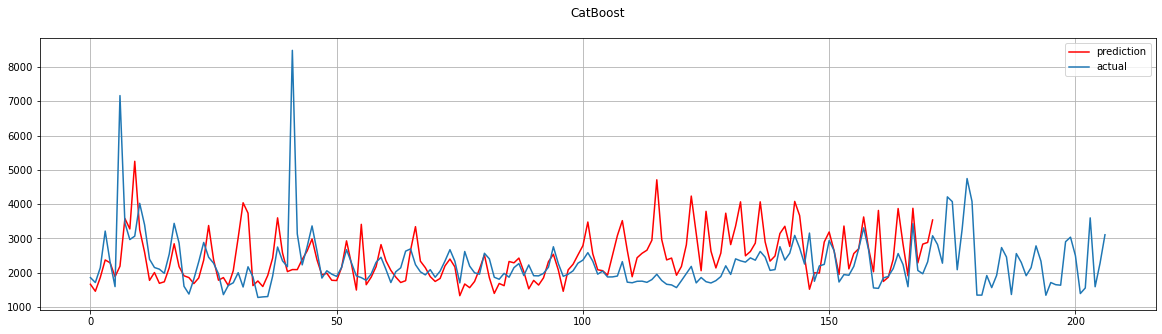

In [129]:
plt.figure(figsize=(20, 5))
plt.plot(preds1, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.grid(True)
plt.legend(loc="best")
plt.title(f"CatBoost\n");

In [106]:
print(f'Mean absolute error {mean_absolute_error(y_test, preds1)}')
print(f'Mean absolute percetage error {mean_absolute_percentage_error(y_test, preds1)}')
print(f'Mean squared error {mean_squared_error(y_test, preds1)}')

Mean absolute error 535.9099017306603
Mean absolute percetage error 0.22412768566299035
Mean squared error 780525.5665560773


## Применил кросс-валидацию для этих моделей 

In [107]:
y = pd.concat([y_train, y_test], axis=0)
X = pd.concat([X_train, X_test], axis=0)

In [108]:
errors = []

tscv = TimeSeriesSplit(n_splits=5)

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.values[train_index], X.values[test_index]
    y_train, y_test = y.values[train_index], y.values[test_index]
    model = LinearRegression()
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    errors.append(mean_absolute_percentage_error(y_test, preds))
    
np.mean(errors)

0.20769875008220956

In [109]:
errors1 = []
tscv1 = TimeSeriesSplit(n_splits=5)

for train_index, test_index in tscv1.split(X):
    X_train, X_test = X.values[train_index], X.values[test_index]
    y_train, y_test = y.values[train_index], y.values[test_index]
    model = CatBoostRegressor(n_estimators=300, verbose=0)
    model.fit(X_train, y_train)
    preds1 = model.predict(X_test)
    errors1.append(mean_absolute_percentage_error(y_test, preds1))
    
np.mean(errors1)

0.17514960219628709

In [98]:
def preprocess_data(data, lag_start=5, lag_end=20, test_size=0.15):

    data = pd.DataFrame(data.copy())

    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(data) * (1 - test_size))

    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data[f"lag_{i}"] = data.item_cnt_day.shift(i)

    data["week"] = data.index.week
    data["month"] = data.index.month
    data["year"] = data.index.year

    # считаем средние только по тренировочной части, чтобы избежать лика
    data["week_average"] = list(map(code_mean(data[:test_index], "week", "item_cnt_day").get, data.week))
    data["month_average"] = list(map(code_mean(data[:test_index], "month", "item_cnt_day").get, data.month))
    data["year_average"] = list(map(code_mean(data[:test_index], "year", "item_cnt_day").get, data.year))
    
    # выкидываем закодированные средними признаки
    data.drop([ "week", 'month', 'year'], axis=1, inplace=True)

    data = data.dropna()
    data = data.reset_index(drop=True)

    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["item_cnt_day"], axis=1)
    y_train = data.loc[:test_index]["item_cnt_day"]
    X_test = data.loc[test_index:].drop(["item_cnt_day"], axis=1)
    y_test = data.loc[test_index:]["item_cnt_day"]

    return X_train, X_test, y_train, y_test

In [99]:
def train_model(trial):
    train_x, valid_x, train_y, valid_y = preprocess_data(sales_gr1, test_size=0.1, lag_start=12, lag_end=48)
    
    params = {
        "objective": trial.suggest_categorical("loss_function", ["RMSE"]),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1),
        "num_trees": trial.suggest_int("num_tree", 1, 100),
        "depth": trial.suggest_int("depth", 1, 10),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli"]
        ),
    }

    if params["bootstrap_type"] == "Bayesian":
        params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif params["bootstrap_type"] == "Bernoulli":
        params["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    gbm = CatBoostRegressor(**params)

    gbm.fit(train_x, train_y, eval_set=[(valid_x, valid_y)], verbose=0, early_stopping_rounds=100)

    preds = gbm.predict(valid_x)
    
    mape_errors = mean_absolute_percentage_error(valid_y, preds)
    print(f'MAPE: {mape_errors}')
    
    return mape_errors 

In [100]:
study = optuna.create_study(direction="minimize")
study.optimize(train_model, n_trials=20, timeout=100)

print(f"Number of finished trials: {len(study.trials)}")

print("Best trial:")
trial = study.best_trial

print(f"  Value: {trial.value}")

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2025-06-02 00:45:15,289] A new study created in memory with name: no-name-fee0cc51-a57f-4183-9a9a-2c77a199abab
/tmp/ipykernel_2486/1239191499.py:12: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  data["week"] = data.index.week
[I 2025-06-02 00:45:17,970] Trial 0 finished with value: 0.2921658407689301 and parameters: {'loss_function': 'RMSE', 'learning_rate': 0.06145269546122653, 'num_tree': 85, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7113495844400867}. Best is trial 0 with value: 0.2921658407689301.
/tmp/ipykernel_2486/1239191499.py:12: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear 

MAPE: 0.2921658407689301
MAPE: 0.43041372215795554


/tmp/ipykernel_2486/1239191499.py:12: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  data["week"] = data.index.week
[I 2025-06-02 00:45:18,242] Trial 2 finished with value: 0.48634949407912487 and parameters: {'loss_function': 'RMSE', 'learning_rate': 0.07934763106384572, 'num_tree': 21, 'depth': 1, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 3.541763844411787}. Best is trial 0 with value: 0.2921658407689301.
/tmp/ipykernel_2486/1239191499.py:12: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  data["week"] = data.index.wee

MAPE: 0.48634949407912487
MAPE: 0.48824663962976766
MAPE: 0.40267675992571816


/tmp/ipykernel_2486/1239191499.py:12: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  data["week"] = data.index.week
[I 2025-06-02 00:45:18,552] Trial 5 finished with value: 0.5706489698657601 and parameters: {'loss_function': 'RMSE', 'learning_rate': 0.010748422549889277, 'num_tree': 44, 'depth': 2, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6255774019751588}. Best is trial 0 with value: 0.2921658407689301.
/tmp/ipykernel_2486/1239191499.py:12: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  data["week"] = data.index.week


MAPE: 0.5706489698657601


[I 2025-06-02 00:45:18,943] Trial 6 finished with value: 0.27406600088697014 and parameters: {'loss_function': 'RMSE', 'learning_rate': 0.08549438764806788, 'num_tree': 95, 'depth': 6, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5662704573063043}. Best is trial 6 with value: 0.27406600088697014.


MAPE: 0.27406600088697014


/tmp/ipykernel_2486/1239191499.py:12: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  data["week"] = data.index.week
[I 2025-06-02 00:45:20,759] Trial 7 finished with value: 0.3998757420664901 and parameters: {'loss_function': 'RMSE', 'learning_rate': 0.036380237669381234, 'num_tree': 39, 'depth': 10, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.36577117072842324}. Best is trial 6 with value: 0.27406600088697014.
/tmp/ipykernel_2486/1239191499.py:12: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  data["week"] = data.index.week
[I 20

MAPE: 0.3998757420664901
MAPE: 0.42680759587999506


/tmp/ipykernel_2486/1239191499.py:12: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  data["week"] = data.index.week
[I 2025-06-02 00:45:20,983] Trial 9 finished with value: 0.3484779063656106 and parameters: {'loss_function': 'RMSE', 'learning_rate': 0.061832094135237395, 'num_tree': 35, 'depth': 3, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 3.993011706742556}. Best is trial 6 with value: 0.27406600088697014.
/tmp/ipykernel_2486/1239191499.py:12: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  data["week"] = data.index.we

MAPE: 0.3484779063656106


[I 2025-06-02 00:45:21,764] Trial 10 finished with value: 0.29442056217962076 and parameters: {'loss_function': 'RMSE', 'learning_rate': 0.09882287557867153, 'num_tree': 99, 'depth': 7, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 9.932986250358208}. Best is trial 6 with value: 0.27406600088697014.


MAPE: 0.29442056217962076


/tmp/ipykernel_2486/1239191499.py:12: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  data["week"] = data.index.week
[I 2025-06-02 00:45:23,271] Trial 11 finished with value: 0.28598274580512434 and parameters: {'loss_function': 'RMSE', 'learning_rate': 0.08728268471263667, 'num_tree': 96, 'depth': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7062135155165212}. Best is trial 6 with value: 0.27406600088697014.


MAPE: 0.28598274580512434


/tmp/ipykernel_2486/1239191499.py:12: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  data["week"] = data.index.week
[I 2025-06-02 00:45:23,869] Trial 12 finished with value: 0.27377577830266264 and parameters: {'loss_function': 'RMSE', 'learning_rate': 0.09952515344680748, 'num_tree': 73, 'depth': 7, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.18845315027899234}. Best is trial 12 with value: 0.27377577830266264.


MAPE: 0.27377577830266264


/tmp/ipykernel_2486/1239191499.py:12: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  data["week"] = data.index.week
[I 2025-06-02 00:45:24,387] Trial 13 finished with value: 0.2894840841288112 and parameters: {'loss_function': 'RMSE', 'learning_rate': 0.09836707502777471, 'num_tree': 71, 'depth': 7, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.11245728315419896}. Best is trial 12 with value: 0.27377577830266264.


MAPE: 0.2894840841288112


/tmp/ipykernel_2486/1239191499.py:12: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  data["week"] = data.index.week
[I 2025-06-02 00:45:24,958] Trial 14 finished with value: 0.27746652600843413 and parameters: {'loss_function': 'RMSE', 'learning_rate': 0.07847712042604199, 'num_tree': 67, 'depth': 7, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.34856542913425803}. Best is trial 12 with value: 0.27377577830266264.


MAPE: 0.27746652600843413


/tmp/ipykernel_2486/1239191499.py:12: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  data["week"] = data.index.week
[I 2025-06-02 00:45:25,322] Trial 15 finished with value: 0.2927701984401516 and parameters: {'loss_function': 'RMSE', 'learning_rate': 0.08553553508511168, 'num_tree': 78, 'depth': 6, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.36764067549187973}. Best is trial 12 with value: 0.27377577830266264.


MAPE: 0.2927701984401516


/tmp/ipykernel_2486/1239191499.py:12: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  data["week"] = data.index.week
[I 2025-06-02 00:45:27,235] Trial 16 finished with value: 0.5932547515594372 and parameters: {'loss_function': 'RMSE', 'learning_rate': 0.005286876829819098, 'num_tree': 58, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.20536971911675372}. Best is trial 12 with value: 0.27377577830266264.


MAPE: 0.5932547515594372


/tmp/ipykernel_2486/1239191499.py:12: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  data["week"] = data.index.week
[I 2025-06-02 00:45:27,659] Trial 17 finished with value: 0.26982441889452613 and parameters: {'loss_function': 'RMSE', 'learning_rate': 0.07273487995398863, 'num_tree': 87, 'depth': 6, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.47955517405643944}. Best is trial 17 with value: 0.26982441889452613.
/tmp/ipykernel_2486/1239191499.py:12: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  data["week"] = data.index.week
[I 2

MAPE: 0.26982441889452613
MAPE: 0.27769989720806737


/tmp/ipykernel_2486/1239191499.py:12: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  data["week"] = data.index.week
[I 2025-06-02 00:45:28,795] Trial 19 finished with value: 0.3895530026877862 and parameters: {'loss_function': 'RMSE', 'learning_rate': 0.02342021667589182, 'num_tree': 58, 'depth': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.2676307910781812}. Best is trial 17 with value: 0.26982441889452613.


MAPE: 0.3895530026877862
Number of finished trials: 20
Best trial:
  Value: 0.26982441889452613
  Params: 
    loss_function: RMSE
    learning_rate: 0.07273487995398863
    num_tree: 87
    depth: 6
    boosting_type: Plain
    bootstrap_type: Bernoulli
    subsample: 0.47955517405643944
